In [7]:
from __future__ import division
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import KFold, StratifiedKFold
import sklearn as sk
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing
import warnings # to silence convergence warnings

# seaborn can be used to "prettify" default matplotlib plots by importing and setting as default
import seaborn as sns
sns.set() # Set searborn as default

## Load dataset


In [9]:
# read in the data to pandas dataframes and convert to numpy arrays
GXtrain = pd.read_csv('GolubGXtrain.csv', header=None)
GXtest = pd.read_csv('GolubGXtest.csv', header=None)

Xtrain = np.array(GXtrain.loc[:, GXtrain.columns != 0])
Ytrain = np.array(GXtrain.loc[:, GXtrain.columns == 0]).ravel()

Xtest = np.array(GXtest.loc[:, GXtest.columns != 0])
Ytest = np.array(GXtest.loc[:, GXtest.columns == 0]).ravel()

### 2 We have a data material (Golub et al 1999) with gene expression levels from 72 patients with two forms of leukemia, acute myeloid leukemia (AML) and acute lymphoblastic leukemia (ALL). Gene expression levels (how actively the cells are using the information in di
erent genes) are measured for 7127 genes. We would like to build a biomarker for classification of the two cancer forms. Ideally, we would like to use onlya few variables.

> a) How can you use logistic regression here?
Do it!
> b) Build a classifier for training data in GolubGXtrain.csv. What regularization method do you prefer if you want to have few genes in the biomarker?
L1

CV lambda 1 std rule 0.27


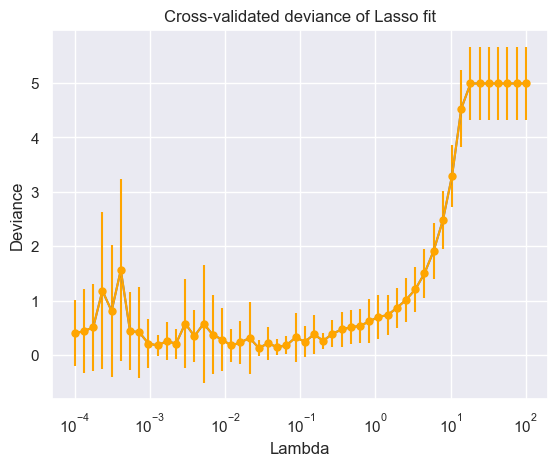

In [51]:
def devianceFunc(ytrue, yscores):
    return 2*sk.metrics.log_loss(ytrue, yscores, normalize=False, labels=[0,1])

lambdas = np.logspace(-4,2,50)
K = 10
CV = KFold(n_splits=K, shuffle=True)
X_standardizer = preprocessing.StandardScaler()

coefs = np.zeros((K,len(lambdas), Xtrain.shape[1])) # store the coefficients
accuracy = np.zeros((K, len(lambdas))) # store the accuracy

deviance = np.zeros((K, len(lambdas)))
with warnings.catch_warnings(): # done to disable all the convergence warnings from elastic net
    warnings.simplefilter("ignore")
    
    #Setup CrossValidation loop
    for k, (train_index, test_index) in enumerate(CV.split(Xtrain, Ytrain)):
        X_train, X_test = Xtrain[train_index], Xtrain[test_index]
        y_train, y_test = Ytrain[train_index], Ytrain[test_index]
        
        #Setup loop over possible lambdas
        for i, lmbd in enumerate(lambdas):
            
            #For each lambda run logistic regression
            lo = LogisticRegression(penalty= 'l1', C=1/lmbd, solver='liblinear')
            lo.fit(X_standardizer.fit_transform(X_train), y_train)

            #Predict the data in the test fold
            y_est = lo.predict(X_standardizer.transform(X_test))
            #compute the deviance
            deviance[k,i] = devianceFunc(y_test, lo.predict_proba(X_standardizer.transform(X_test)))

            coefs[k,i,:] = lo.coef_
            accuracy[k,i] = sk.metrics.accuracy_score(y_test, y_est)
            
#Compute the average and std of the deviance over CV folds
testError = np.mean(deviance, axis=0)
testStd = np.std(deviance, axis=0)

#Select the optimal lambda using the 1-std-rule
Lambda_CV_1StdRule = lambdas[np.argmin(testError) + np.argmax(testError < testError[np.argmin(testError)] + testStd[np.argmin(testError)])]
print("CV lambda 1 std rule %0.2f" % Lambda_CV_1StdRule)

plt.figure()
plt.errorbar(lambdas, testError, testStd, marker='.', color='orange', markersize=10)
plt.semilogx(lambdas, testError)

plt.xlabel("Lambda")
plt.ylabel("Deviance")
plt.title("Cross-validated deviance of Lasso fit")
plt.show()

> c) How many variables do you end up with?

In [52]:
# After we know our optimal lambda we can create our model with our training set
lo = LogisticRegression(penalty= 'l1', C=1/lambdas[np.argmin(testError)], solver='liblinear')

lo.fit(X_standardizer.fit_transform(Xtrain), Ytrain)

nrCoefs = np.count_nonzero(lo.coef_)
print("The number of non-zero coefficients in our optimal model is: %d" % nrCoefs)

The number of non-zero coefficients in our optimal model is: 112


> d) Use the obtained model to calculate accuracy on the test data.

In [53]:
#Predict the class using the model trained above and calculate the accuracy

accuracy = sk.metrics.accuracy_score(Ytest, lo.predict(X_standardizer.transform(Xtest)))
print("The accuracy for our optimal model is: %0.2f" % accuracy)

The accuracy for our optimal model is: 0.97
